In [2]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import random
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.lancaster import LancasterStemmer
import nltk
import re
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Bidirectional, Embedding, Dropout
from keras.callbacks import ModelCheckpoint



Using TensorFlow backend.


In [3]:
def load_dataset(filename):
    df = pd.read_csv(filename, encoding = "latin1", names = ["Sentence", "Intent"])
    print(df.head())
    intent = df["Intent"]
    unique_intent = list(set(intent))
    sentences = list(df["Sentence"])
  
    return (intent, unique_intent, sentences)
  


In [4]:
intent, unique_intent, sentences = load_dataset("data.csv")

                   Sentence  Intent
0              Order please   order
1      Ship this item to me   order
2  Can I order that please?   order
3        Where is the help?  common
4           Purchase <Item>   order


In [5]:
print(sentences[35])
print(unique_intent)


Are you out of <item>?
['common', 'price', 'order', 'balance']


In [6]:
nltk.download("stopwords")
nltk.download("punkt")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/maxlengdell/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/maxlengdell/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [7]:
#define stemmer
stemmer = LancasterStemmer()

In [8]:
def cleaning(sentences):
    words = []
    for s in sentences:
        clean = re.sub(r'[^ a-z A-Z 0-9]', " ", s)
        w = word_tokenize(clean)
        #stemming
        words.append([i.lower() for i in w])
    
    return words  

In [9]:
cleaned_words = cleaning(sentences)
print(len(cleaned_words))
print(cleaned_words[:2])  
  


237
[['order', 'please'], ['ship', 'this', 'item', 'to', 'me']]


In [10]:
def create_tokenizer(words, filters = '!"#$%&()*+,-./:;<=>?@[\]^_`{|}~'):
    token = Tokenizer(filters = filters)
    token.fit_on_texts(words)
    print(token)
    return token

In [11]:
def max_length(words):
    return(len(max(words, key = len)))
  

In [12]:
word_tokenizer = create_tokenizer(cleaned_words)
vocab_size = len(word_tokenizer.word_index) + 1
max_length = max_length(cleaned_words)

print("Vocab Size = %d and Maximum length = %d" % (vocab_size, max_length))

Vocab Size = 144 and Maximum length = 9


In [13]:
def encoding_doc(token, words):
    return(token.texts_to_sequences(words))

In [14]:
encoded_doc = encoding_doc(word_tokenizer, cleaned_words)
#print(encoded_doc)

In [15]:
def padding_doc(encoded_doc, max_length):
    return(pad_sequences(encoded_doc, maxlen = max_length, padding = "post"))

In [16]:
padded_doc = padding_doc(encoded_doc, max_length)

In [17]:
padded_doc[:5]

array([[12, 28,  0,  0,  0,  0,  0,  0,  0],
       [97,  7,  1, 21,  9,  0,  0,  0,  0],
       [25,  2, 12, 46, 28,  0,  0,  0,  0],
       [55,  3, 13, 31,  0,  0,  0,  0,  0],
       [33,  1,  0,  0,  0,  0,  0,  0,  0]], dtype=int32)

In [18]:
print("Shape of padded docs = ",padded_doc.shape)

Shape of padded docs =  (237, 9)


In [19]:
#tokenizer with filter changed
output_tokenizer = create_tokenizer(unique_intent, filters = '!"#$%&()*+,-/:;<=>?@[\]^`{|}~')


In [20]:
output_tokenizer.word_index

{'common': 1, 'price': 2, 'order': 3, 'balance': 4}

In [21]:
encoded_output = encoding_doc(output_tokenizer, intent)

In [22]:
encoded_output = np.array(encoded_output).reshape(len(encoded_output), 1)

In [23]:
encoded_output.shape

(237, 1)

In [24]:
def one_hot(encode):
    o = OneHotEncoder(sparse = False)
    return(o.fit_transform(encode))

In [25]:
output_one_hot = one_hot(encoded_output)

In [26]:
output_one_hot.shape

(237, 4)

In [27]:
from sklearn.model_selection import train_test_split

In [28]:
train_X, val_X, train_Y, val_Y = train_test_split(padded_doc, output_one_hot, shuffle = True, test_size = 0.2)


In [29]:
print("Shape of train_X = %s and train_Y = %s" % (train_X.shape, train_Y.shape))
print("Shape of val_X = %s and val_Y = %s" % (val_X.shape, val_Y.shape))

Shape of train_X = (189, 9) and train_Y = (189, 4)
Shape of val_X = (48, 9) and val_Y = (48, 4)


In [30]:
def create_model(vocab_size, max_length):
    model = Sequential()
    model.add(Embedding(vocab_size, 128, input_length = max_length, trainable = True))
    model.add(Bidirectional(LSTM(128)))
#   model.add(LSTM(128))
    model.add(Dense(32, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(4, activation = "softmax"))
  
    return model





In [31]:
model = create_model(vocab_size, max_length)

model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 9, 128)            18432     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               263168    
_________________________________________________________________
dense_1 (Dense)              (None, 32)                8224      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 132       
Total params: 289,956
Trainable params: 289,956
Non-trainable params: 0
_________________________________________________________________


In [32]:
filename = 'model.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(train_X, train_Y, epochs = 50, batch_size = 32, validation_data = (val_X, val_Y), callbacks = [checkpoint])

/Users/maxlengdell/opt/anaconda3/envs/nnD7046E/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 189 samples, validate on 48 samples
Epoch 1/50
189/189 [==============================] - 4s 21ms/step - loss: 1.3765 - accuracy: 0.3651 - val_loss: 1.3778 - val_accuracy: 0.1875

Epoch 00001: val_loss improved from inf to 1.37783, saving model to model.h5
Epoch 2/50
189/189 [==============================] - 0s 1ms/step - loss: 1.3502 - accuracy: 0.3968 - val_loss: 1.3563 - val_accuracy: 0.2917

Epoch 00002: val_loss improved from 1.37783 to 1.35626, saving model to model.h5
Epoch 3/50
189/189 [==============================] - 0s 1ms/step - loss: 1.3006 - accuracy: 0.4444 - val_loss: 1.3028 - val_accuracy: 0.4583

Epoch 00003: val_loss improved from 1.35626 to 1.30277, saving model to model.h5
Epoch 4/50
189/189 [==============================] - 0s 1ms/step - loss: 1.2373 - accuracy: 0.5026 - val_loss: 1.2275 - val_accuracy: 0.4583

Epoch 00004: val_loss improved from 1.30277 to 1.22753, saving model to model.h5
Epoch 5/50
189/189 [==============================] - 0s 1ms/s

189/189 [==============================] - 0s 2ms/step - loss: 0.0324 - accuracy: 0.9894 - val_loss: 0.0190 - val_accuracy: 1.0000

Epoch 00040: val_loss did not improve from 0.00210
Epoch 41/50
189/189 [==============================] - 0s 2ms/step - loss: 0.0169 - accuracy: 1.0000 - val_loss: 0.0187 - val_accuracy: 1.0000

Epoch 00041: val_loss did not improve from 0.00210
Epoch 42/50
189/189 [==============================] - 0s 2ms/step - loss: 0.0204 - accuracy: 0.9894 - val_loss: 0.0168 - val_accuracy: 1.0000

Epoch 00042: val_loss did not improve from 0.00210
Epoch 43/50
189/189 [==============================] - 0s 2ms/step - loss: 0.0172 - accuracy: 0.9947 - val_loss: 0.0123 - val_accuracy: 1.0000

Epoch 00043: val_loss did not improve from 0.00210
Epoch 44/50
189/189 [==============================] - 0s 2ms/step - loss: 0.0086 - accuracy: 1.0000 - val_loss: 0.0095 - val_accuracy: 1.0000

Epoch 00044: val_loss did not improve from 0.00210
Epoch 45/50
189/189 [================

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


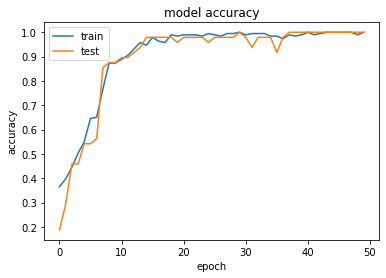

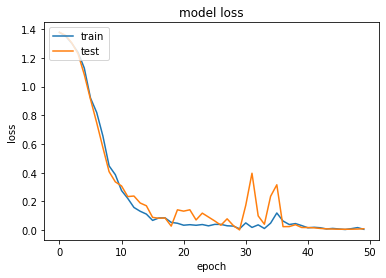

In [33]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [34]:
 model = load_model("model.h5")

/Users/maxlengdell/opt/anaconda3/envs/nnD7046E/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [36]:
def predictions(text):
    clean = re.sub(r'[^ a-z A-Z 0-9]', " ", text)
    test_word = word_tokenize(clean)
    test_word = [w.lower() for w in test_word]
    test_ls = word_tokenizer.texts_to_sequences(test_word)
    print(test_word)
    #Check for unknown words
    if [] in test_ls:
        test_ls = list(filter(None, test_ls))
    
    test_ls = np.array(test_ls).reshape(1, len(test_ls))
 
    x = padding_doc(test_ls, max_length)
  
    pred = model.predict_proba(x)
  
  
    return pred


  

In [37]:
def get_final_output(pred, classes):
    predictions = pred[0]
 
    classes = np.array(classes)
    ids = np.argsort(-predictions)
    classes = classes[ids]
    predictions = -np.sort(-predictions)
 
    for i in range(pred.shape[1]):
        print("%s has confidence = %s" % (classes[i], (predictions[i])))



In [38]:
#Price
text = "How much does it cost?"
pred = predictions(text)
get_final_output(pred, unique_intent)

['how', 'much', 'does', 'it', 'cost']
price has confidence = 0.9999995
common has confidence = 4.6431657e-07
balance has confidence = 2.1683059e-08
order has confidence = 1.8531647e-08


In [39]:
#Balance
text = "how many pants are in stock?"
pred = predictions(text)
get_final_output(pred, unique_intent)

['how', 'many', 'pants', 'are', 'in', 'stock']
balance has confidence = 0.999997
common has confidence = 2.9485116e-06
price has confidence = 1.8208308e-09
order has confidence = 1.635819e-09


In [40]:
#Order
text = "Can I order 3 pants"
pred = predictions(text)
get_final_output(pred, unique_intent)

['can', 'i', 'order', '3', 'pants']
order has confidence = 0.9999987
common has confidence = 1.3443083e-06
balance has confidence = 8.3149505e-09
price has confidence = 4.5144594e-10


In [81]:
#Common
text = "I need help"
pred = predictions(text)
get_final_output(pred, unique_intent)

['i', 'need', 'help']
order has confidence = 0.84783244
common has confidence = 0.13630454
price has confidence = 0.0087884525
balance has confidence = 0.0070746485


In [41]:
##SPACY IMPORTS
import spacy

nlp = spacy.load('en_core_web_sm')
nlp.pipe_names
ner = nlp.get_pipe('ner')

import random
from spacy.util import minibatch, compounding
from pathlib import Path



In [42]:
#Load entity model

output_dir = Path('./Models/')

print("loading model form", output_dir)
nlp_updated = spacy.load(output_dir)
doc = nlp_updated("Those pants are really good")
print("Entities", [(ent.text, ent.label_) for ent in doc.ents])

loading model form Models


/Users/maxlengdell/opt/anaconda3/envs/nnD7046E/lib/python3.6/site-packages/spacy/util.py:275: UserWarning: [W031] Model 'en_core_web_sm' (2.2.0) requires spaCy v2.2 and is incompatible with the current spaCy version (2.3.2). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


Entities [('Those', 'ORG'), ('pants', 'PRODUCT')]


In [43]:
opening_lines = ['Hello, what can I help you with?',
                'How can I help you?',
                'Whats on your mind today?']
stock_info = [(['gloves', '299', '3']), #product name, price, balance
             (['shoes', '899', '5']),
             (['pants', '450', '10'])]

def randomOpening():
    index = random.randint(0,len(opening_lines)-1)
    print(opening_lines[index])
def getProductPrice(product):
    for prod in stock_info:
        if(prod[0]==product):
            return prod[1]
def getProductBalance(product):
    for prod in stock_info:
        if(prod[0]==product):
            return prod[2]
def printProducts():
    for prod in stock_info:
        print(prod[0])

In [44]:
def getEntity(sentence):
    #print(sentence)
    doc = nlp_updated(sentence)
    #print("Entities", [(ent.text, ent.label_) for ent in doc.ents])  
    text = []
    label = []
    for ent in doc.ents:
        text.append(ent.text)
        label.append(ent.label_)
    ret_arr = [text,label]
    return doc.ents

In [45]:
def getIntent(sentence):
    pred = predictions(sentence)
    guess = pred[0]
    
    classes = np.array(unique_intent)
    ids = np.argsort(-pred)
    classes = classes[ids]
    predict = -np.sort(-pred)
    
    #print("Network guessed:", classes[0][0])
    return classes[0][0]



In [46]:
def priceFunc(entities):
    print("Oh, so you want to know the price of your product?")
    for ent in entities:
        print(ent.text, ent.label_)

        if(ent.label_=="PRODUCT"):
            print("The price of " + ent.text + " is " + getProductPrice(ent.text))
        else:
            print("I'm sorry, i did not find that product. Did you mean any of these?")
            printProducts()
            
            

def balanceFunc(entities):
    print("Do you want to know the storage count of your product?")
    for ent in entities:
        if(ent.label_=="PRODUCT"):
            print("The balance of " + ent.text + " is " + getProductBalance(ent.text))
            
        else:
            print("I'm sorry, i did not find that product. Did you mean any of these?")
            printProducts()


def orderFunc(entities):
    print("Print order info")
    for ent in entities:

        if(ent.label_=="PRODUCT"):
            print("You have placed an order on " + ent.text)
        else:
            print("I'm sorry, i did not find that product. Did you mean any of these?")
            printProducts()
            
def commonFunf(entities):
    print("I'm sorry, i did not understand. Try rephrasing the sentence.")

In [48]:
#Ask user from the opening lines-list
#identify intent
#identify entities
#send to corresponding function and return answer
introduction = "Welcome to our e-com chatbot for a fashion store. Place a order, check the availability of a product or its price. What does pants cost? How many gloves are in stock?"
def cli():
    print(introduction)
    while True:
        randomOpening()
        user_input = input("Ask the chatbot something: ")
        if(user_input=="quit"):
            break
        else:
            intent = getIntent(user_input)
            entity = getEntity(user_input)
            if(intent=="price"):
                priceFunc(entity)
            elif(intent=="balance"):
                balanceFunc(entity)
            elif(intent=="order"):
                orderFunc(entity)
            else:
                commonFunc(entities)
            print("***********************************")


                

        
cli()

SyntaxError: EOL while scanning string literal (<ipython-input-48-10eba50db569>, line 5)